# Prévision de consommation électrique — SARIMA vs LSTM (H=24)

## Introduction
La consommation électrique présente des cycles forts (journée, semaine, saison) et des variations dues à des facteurs externes (température, calendrier). Pouvoir anticiper la charge à 24h est un cas d’usage classique pour :

- planifier la production et les achats d’énergie,
- réduire les coûts (pénalités, recours à des moyens de production coûteux),
- mieux gérer les pics de consommation.

Ce notebook présente une démarche simple et reproductible :

1. mise en place du projet et chargement des données,
2. analyse exploratoire (EDA),
3. entraînement et évaluation de deux approches de prévision multi-horizon (H=24) :
   - SARIMA/SARIMAX (statistique, saisonnalité journalière)
   - LSTM (deep learning, prédiction directe du vecteur 24h)
4. comparaison des performances (MAE/RMSE/MAPE), visualisations (true vs pred) et analyse d’erreurs.


In [1]:
# --- Setup ---
from __future__ import annotations

import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd

# Résolution robuste de la racine du repo pour que `import src...` marche
CWD = Path.cwd()
if (CWD / "src").exists():
    REPO_ROOT = CWD
elif (CWD.parent / "src").exists():
    REPO_ROOT = CWD.parent
else:
    REPO_ROOT = CWD

if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from src.data_processing import (
    add_lag_features,
    add_time_features,
    load_consumption_data,
    load_opsd_weather,
    merge_weather_features,
    preprocess_household_hourly,
)
from src.evaluate import evaluate_forecasts, sarima_rolling_forecast
from src.models import LSTMForecaster
from src.train import make_sequences
from src.utils import temporal_split

plt.style.use("seaborn-v0_8-darkgrid")
pd.options.display.max_columns = 50
pd.options.display.width = 140

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE


device(type='cpu')

## 1) Chargement des données

On utilise les CSV présents dans `data/` (OPSD). Tu peux changer `COUNTRY`.


In [2]:
DATA_DIR = REPO_ROOT / "data"
consumption_path = DATA_DIR / "consumption_data.csv"
weather_path = DATA_DIR / "weather_data.csv"

assert consumption_path.exists(), f"Missing {consumption_path}"
assert weather_path.exists(), f"Missing {weather_path}"

COUNTRY = "FR"
HORIZON = 24
INPUT_WIDTH = 24

raw = load_consumption_data(str(consumption_path), country=COUNTRY)
hourly = preprocess_household_hourly(raw)

# Features: calendrier + lags/rolling + température
feat = add_time_features(hourly, holidays_country=COUNTRY)
feat = add_lag_features(feat, target_col="load", lags=(1, 24), rolling_windows=(3, 24), dropna=True)

temp = load_opsd_weather(
    str(weather_path),
    datetime_col="utc_timestamp",
    temperature_col=f"{COUNTRY}_temperature",
)
feat = merge_weather_features(feat, temp)
feat = feat.dropna(subset=["load"])  # sécurité

feat.head(), feat.shape

(                        load  hour  dayofweek  month  is_weekend  is_holiday  hour_sin  hour_cos  dayofweek_sin  dayofweek_cos  load_lag1  \
 utc_timestamp                                                                                                                               
 2015-01-02 01:00:00  64522.0     1          4      1       False       False  0.258819  0.965926      -0.433884      -0.900969    65510.0   
 2015-01-02 02:00:00  61798.0     2          4      1       False       False  0.500000  0.866025      -0.433884      -0.900969    64522.0   
 2015-01-02 03:00:00  60686.0     3          4      1       False       False  0.707107  0.707107      -0.433884      -0.900969    61798.0   
 2015-01-02 04:00:00  62060.0     4          4      1       False       False  0.866025  0.500000      -0.433884      -0.900969    60686.0   
 2015-01-02 05:00:00  64662.0     5          4      1       False       False  0.965926  0.258819      -0.433884      -0.900969    62060.0   
 
    

## 2) Analyse exploratoire (EDA)

On visualise : tendance globale, profil horaire, effet weekend.


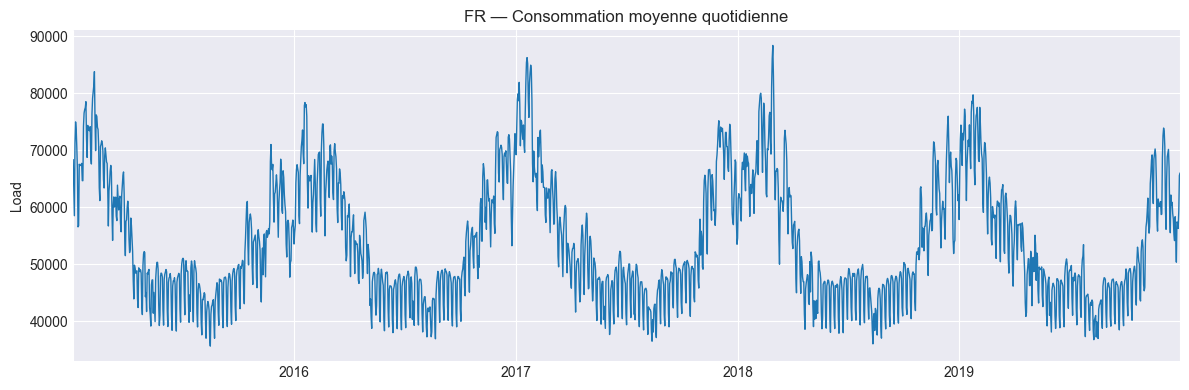

In [3]:
series = feat["load"].rename("load")

global_daily = series.resample("D").mean()
fig, ax = plt.subplots(figsize=(12, 4))
global_daily.plot(ax=ax, color="tab:blue", linewidth=1)
ax.set_title(f"{COUNTRY} — Consommation moyenne quotidienne")
ax.set_xlabel("")
ax.set_ylabel("Load")
plt.tight_layout()
plt.show()

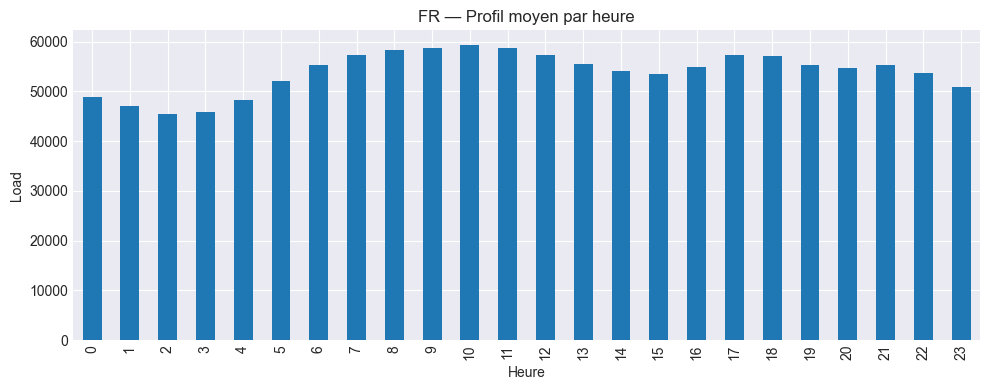

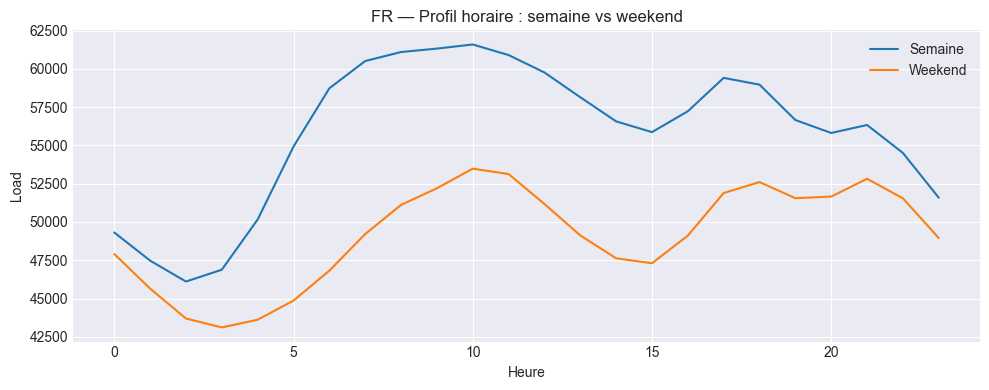

In [4]:
hod = series.groupby(series.index.hour).mean()
fig, ax = plt.subplots(figsize=(10, 4))
hod.plot(kind="bar", ax=ax, color="tab:blue")
ax.set_title(f"{COUNTRY} — Profil moyen par heure")
ax.set_xlabel("Heure")
ax.set_ylabel("Load")
plt.tight_layout()
plt.show()

tmp = series.to_frame()
tmp["hour"] = tmp.index.hour
tmp["is_weekend"] = tmp.index.weekday >= 5
pivot = tmp.groupby(["is_weekend", "hour"]).mean().unstack(0)["load"]
pivot.columns = ["Semaine", "Weekend"]
fig, ax = plt.subplots(figsize=(10, 4))
pivot.plot(ax=ax)
ax.set_title(f"{COUNTRY} — Profil horaire : semaine vs weekend")
ax.set_xlabel("Heure")
ax.set_ylabel("Load")
plt.tight_layout()
plt.show()

## 3) Split temporel (train/val/test)

Découpage chronologique 70/15/15.


In [5]:
train_df, val_df, test_df = temporal_split(feat, train_end=None, val_end=None)
len(train_df), len(val_df), len(test_df)

(30638, 6566, 6566)

## 4) SARIMA (accéléré)

On **ne change pas SARIMA**. Il est accéléré via un `stride` : on ne fait pas une prévision à chaque heure.

- `SARIMA_STRIDE=1` : rolling complet (très lent)
- `SARIMA_STRIDE=24` : 1 forecast par jour (rapide)

On comparera le LSTM sur les **mêmes origines**.


In [6]:
SARIMA_STRIDE = 24

train_series = train_df["load"]
test_series = test_df["load"]

sarima_y_true, sarima_y_pred = sarima_rolling_forecast(
    train_series=train_series,
    test_series=test_series,
    order=(1, 0, 1),
    seasonal_order=(1, 0, 1, 24),
    horizon=HORIZON,
    warm_start=INPUT_WIDTH,
    stride=SARIMA_STRIDE,
    max_points=None,
    max_steps=None,
)

sarima_metrics = evaluate_forecasts(sarima_y_true, sarima_y_pred)
sarima_y_true.shape, sarima_metrics

((272, 24),
 {'MAE': 1995.7839012755967,
  'RMSE': 3053.0400600073162,
  'MAPE': 4.154338939090511})

## 5) LSTM (meilleure pratique, sans toucher à SARIMA)

Améliorations par rapport à une version “simple” :

- on inclut **la charge passée** dans les features d’entrée (historique observé) en plus des features exogènes
- entraînement avec **validation**, **early stopping**, **ReduceLROnPlateau**, **gradient clipping**
- on recharge le **meilleur modèle** (val loss minimale)

On garde l’architecture LSTM du projet (`src/models.py`) pour rester cohérent.


In [7]:
# Features LSTM
# On inclut la charge 'load' dans X (historique), ce qui est standard en forecasting.
exo_cols = [c for c in feat.columns if c != "load"]
input_feature_cols = ["load"] + exo_cols

# Scalers (train uniquement)
scaler_exo = StandardScaler()
scaler_load = StandardScaler()

scaler_exo.fit(train_df[exo_cols].to_numpy())
scaler_load.fit(train_df[["load"]].to_numpy())

def apply_scalers(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out[exo_cols] = scaler_exo.transform(df[exo_cols].to_numpy())
    out["load"] = scaler_load.transform(df[["load"]].to_numpy())
    return out

train_scaled = apply_scalers(train_df)
val_scaled = apply_scalers(val_df)
test_scaled = apply_scalers(test_df)

# Séquences
X_train, y_train = make_sequences(train_scaled, "load", input_width=INPUT_WIDTH, forecast_horizon=HORIZON, feature_cols=input_feature_cols)
X_val, y_val = make_sequences(val_scaled, "load", input_width=INPUT_WIDTH, forecast_horizon=HORIZON, feature_cols=input_feature_cols)
X_test, y_test = make_sequences(test_scaled, "load", input_width=INPUT_WIDTH, forecast_horizon=HORIZON, feature_cols=input_feature_cols)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((30591, 24, 15),
 (30591, 24),
 (6519, 24, 15),
 (6519, 24),
 (6519, 24, 15),
 (6519, 24))

In [ ]:
# Entraînement LSTM (avec validation + early stopping)
BATCH_SIZE = 128
MAX_EPOCHS = 25
PATIENCE = 7
LR = 1e-3
HIDDEN_SIZE = 64
CLIP_NORM = 1.0

train_loader = DataLoader(
    TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)),
    batch_size=BATCH_SIZE,
    shuffle=True,
)
val_loader = DataLoader(
    TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)),
    batch_size=256,
    shuffle=False,
)

def run_epoch(loader, train: bool):
    if train:
        model.train()
    else:
        model.eval()

    losses = []
    with torch.set_grad_enabled(train):
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            if train:
                optimizer.zero_grad()

            pred = model(xb)
            loss = criterion(pred, yb)

            if train:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
                optimizer.step()

            losses.append(loss.item())

    return float(np.mean(losses))

model = LSTMForecaster(
    input_dim=len(input_feature_cols),
    hidden_size=HIDDEN_SIZE,
    num_layers=1,
    horizon=HORIZON,
    dropout=0.1,
).to(DEVICE)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

best_val = float("inf")
best_state = None
patience_ctr = 0

history = []

for epoch in range(1, MAX_EPOCHS + 1):
    train_loss = run_epoch(train_loader, train=True)
    val_loss = run_epoch(val_loader, train=False)

    scheduler.step(val_loss)

    lr_now = optimizer.param_groups[0]["lr"]
    history.append({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss, "lr": lr_now})

    print(f"Epoch {epoch:02d}/{MAX_EPOCHS} | train={train_loss:.4f} | val={val_loss:.4f} | lr={lr_now:.2e}")

    if val_loss < best_val - 1e-6:
        best_val = val_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        patience_ctr = 0
    else:
        patience_ctr += 1
        if patience_ctr >= PATIENCE:
            print("Early stopping")
            break

if best_state is not None:
    model.load_state_dict(best_state)

hist_df = pd.DataFrame(history)
hist_df.tail()

Epoch 01/50 | train=0.2078 | val=0.0600 | lr=1.00e-03
Epoch 02/50 | train=0.0465 | val=0.0478 | lr=1.00e-03
Epoch 03/50 | train=0.0387 | val=0.0410 | lr=1.00e-03
Epoch 04/50 | train=0.0340 | val=0.0371 | lr=1.00e-03
Epoch 05/50 | train=0.0301 | val=0.0324 | lr=1.00e-03
Epoch 06/50 | train=0.0274 | val=0.0299 | lr=1.00e-03
Epoch 07/50 | train=0.0254 | val=0.0284 | lr=1.00e-03
Epoch 08/50 | train=0.0240 | val=0.0272 | lr=1.00e-03
Epoch 09/50 | train=0.0227 | val=0.0273 | lr=1.00e-03
Epoch 10/50 | train=0.0217 | val=0.0262 | lr=1.00e-03
Epoch 11/50 | train=0.0212 | val=0.0249 | lr=1.00e-03
Epoch 12/50 | train=0.0204 | val=0.0239 | lr=1.00e-03
Epoch 13/50 | train=0.0197 | val=0.0240 | lr=1.00e-03
Epoch 14/50 | train=0.0192 | val=0.0233 | lr=1.00e-03
Epoch 15/50 | train=0.0187 | val=0.0241 | lr=1.00e-03
Epoch 16/50 | train=0.0182 | val=0.0241 | lr=1.00e-03
Epoch 17/50 | train=0.0177 | val=0.0228 | lr=1.00e-03
Epoch 18/50 | train=0.0174 | val=0.0235 | lr=1.00e-03
Epoch 19/50 | train=0.0171 |

,epoch,train_loss,val_loss,lr
32,33,0.013713,0.022367,0.000063
33,34,0.013566,0.022177,0.000063
34,35,0.013542,0.022337,0.000063
35,36,0.013522,0.021775,0.000031
36,37,0.013439,0.022044,0.000031


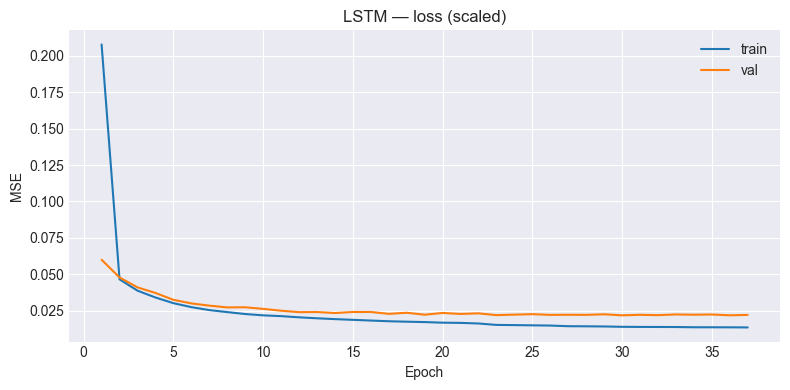

In [9]:
# Courbes d'apprentissage
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(hist_df["epoch"], hist_df["train_loss"], label="train")
ax.plot(hist_df["epoch"], hist_df["val_loss"], label="val")
ax.set_title("LSTM — loss (scaled)")
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE")
ax.legend()
plt.tight_layout()
plt.show()

In [10]:
# Prédictions LSTM sur tout le test, puis sous-échantillonnage pour matcher SARIMA_STRIDE
model.eval()
with torch.no_grad():
    preds_scaled = model(torch.tensor(X_test, dtype=torch.float32).to(DEVICE)).cpu().numpy()

# inversion du scaling (cible)

def invert_load(arr: np.ndarray) -> np.ndarray:
    flat = arr.reshape(-1, 1)
    inv = scaler_load.inverse_transform(flat).reshape(arr.shape)
    return inv

lstm_y_true_full = invert_load(y_test)
lstm_y_pred_full = invert_load(preds_scaled)

# mêmes origines que SARIMA (stride)
sel = np.arange(0, len(lstm_y_true_full), SARIMA_STRIDE)
sel = sel[: len(sarima_y_true)]

lstm_y_true = lstm_y_true_full[sel]
lstm_y_pred = lstm_y_pred_full[sel]

# alignement final
n = min(len(sarima_y_true), len(lstm_y_true))
sarima_y_true = sarima_y_true[:n]
sarima_y_pred = sarima_y_pred[:n]
lstm_y_true = lstm_y_true[:n]
lstm_y_pred = lstm_y_pred[:n]

lstm_metrics = evaluate_forecasts(lstm_y_true, lstm_y_pred)
lstm_y_true.shape, lstm_metrics

((272, 24),
 {'MAE': 1097.2256479597504,
  'RMSE': 1618.1820039304325,
  'MAPE': 2.2182167597669697})

## 6) Comparaison SARIMA vs LSTM

Métriques + graphes :

- bar chart des métriques globales
- MAE par horizon
- True vs prediction (horizon 1)
- exemple de prévision 24h


In [11]:
model_compare = pd.DataFrame({
    "SARIMA": evaluate_forecasts(sarima_y_true, sarima_y_pred),
    "LSTM": evaluate_forecasts(lstm_y_true, lstm_y_pred),
}).T
model_compare

,MAE,RMSE,MAPE
SARIMA,1995.783901,3053.040060,4.154339
LSTM,1097.225648,1618.182004,2.218217


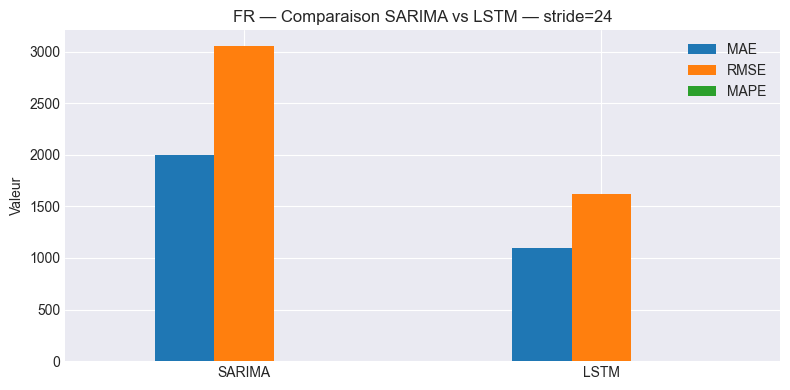

In [12]:
metrics = ["MAE", "RMSE", "MAPE"]
ax = model_compare[metrics].plot(kind="bar", figsize=(8, 4), rot=0)
ax.set_title(f"{COUNTRY} — Comparaison SARIMA vs LSTM — stride={SARIMA_STRIDE}")
ax.set_ylabel("Valeur")
plt.tight_layout()
plt.show()

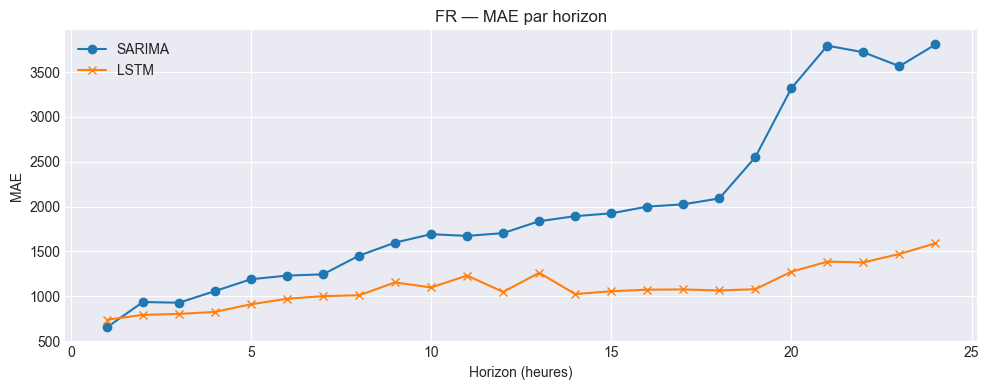

In [13]:
h = np.arange(1, HORIZON + 1)
mae_h_sarima = np.array([np.mean(np.abs(sarima_y_true[:, i] - sarima_y_pred[:, i])) for i in range(HORIZON)])
mae_h_lstm = np.array([np.mean(np.abs(lstm_y_true[:, i] - lstm_y_pred[:, i])) for i in range(HORIZON)])

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(h, mae_h_sarima, marker="o", label="SARIMA")
ax.plot(h, mae_h_lstm, marker="x", label="LSTM")
ax.set_title(f"{COUNTRY} — MAE par horizon")
ax.set_xlabel("Horizon (heures)")
ax.set_ylabel("MAE")
ax.legend()
plt.tight_layout()
plt.show()

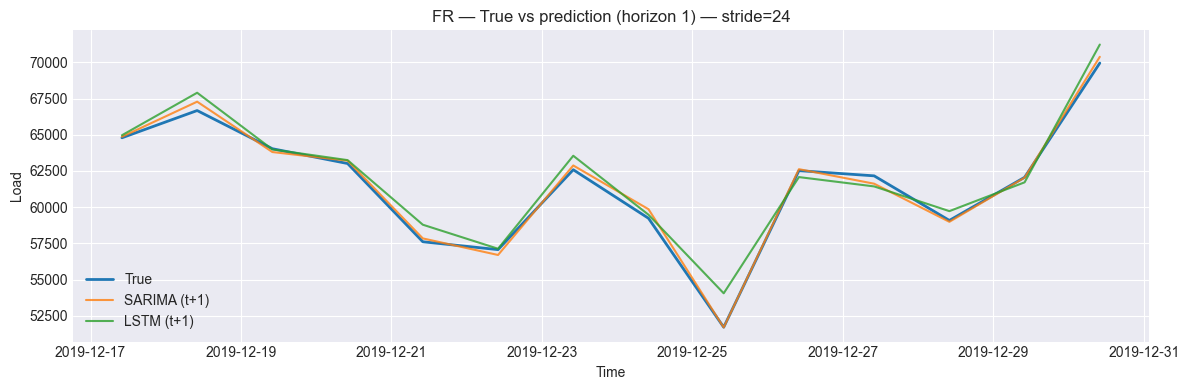

In [14]:
# True vs pred (horizon 1) sur les origines évaluées
idx_test = test_df.index
origin_idx = INPUT_WIDTH + np.arange(0, n * SARIMA_STRIDE, SARIMA_STRIDE)
times = idx_test[origin_idx]

true_1 = sarima_y_true[:, 0]
sarima_pred_1 = sarima_y_pred[:, 0]
lstm_pred_1 = lstm_y_pred[:, 0]

window = min(len(times), 14)
sl = slice(max(0, len(times) - window), len(times))

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(times[sl], true_1[sl], label="True", linewidth=2)
ax.plot(times[sl], sarima_pred_1[sl], label="SARIMA (t+1)", alpha=0.8)
ax.plot(times[sl], lstm_pred_1[sl], label="LSTM (t+1)", alpha=0.8)
ax.set_title(f"{COUNTRY} — True vs prediction (horizon 1) — stride={SARIMA_STRIDE}")
ax.set_xlabel("Time")
ax.set_ylabel("Load")
ax.legend()
plt.tight_layout()
plt.show()

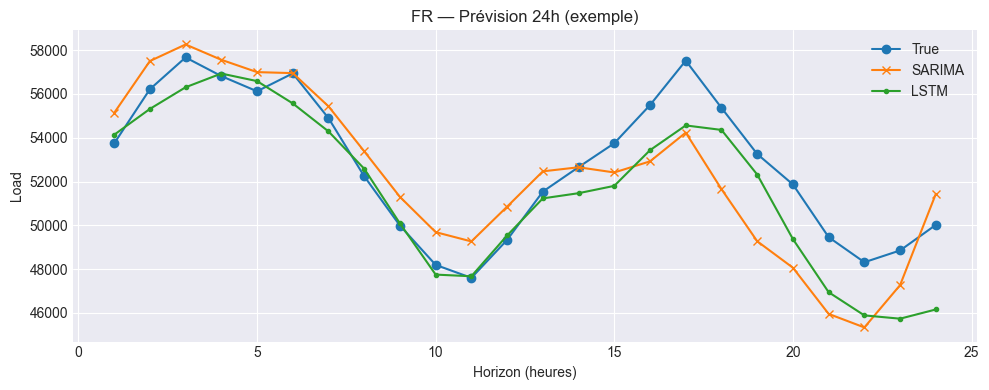

In [15]:
# Exemple de prévision 24h (un point)
sample_idx = min(10, n - 1)
hrs = np.arange(1, HORIZON + 1)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(hrs, sarima_y_true[sample_idx], label="True", marker="o")
ax.plot(hrs, sarima_y_pred[sample_idx], label="SARIMA", marker="x")
ax.plot(hrs, lstm_y_pred[sample_idx], label="LSTM", marker=".")
ax.set_title(f"{COUNTRY} — Prévision 24h (exemple)")
ax.set_xlabel("Horizon (heures)")
ax.set_ylabel("Load")
ax.legend()
plt.tight_layout()
plt.show()

## 7) Analyse d'erreurs

MAE par heure de la journée (horizon 1) pour repérer les périodes difficiles.


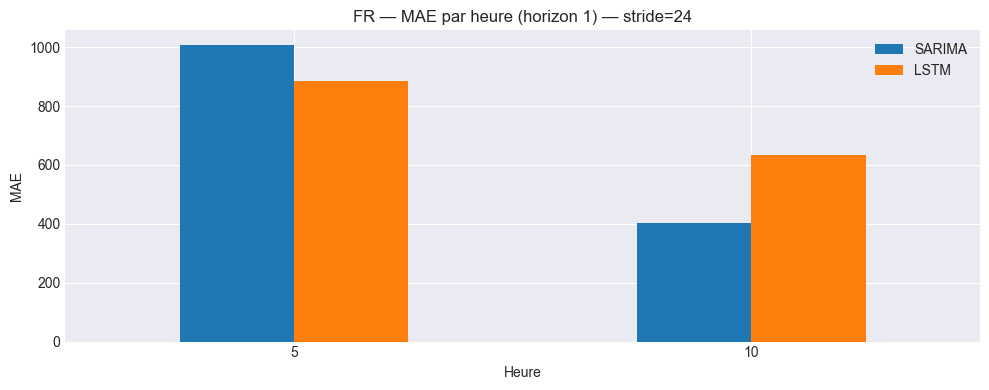

In [16]:
df_err = pd.DataFrame({
    "ts": times,
    "true": true_1,
    "sarima": sarima_pred_1,
    "lstm": lstm_pred_1,
})
df_err["hour"] = pd.to_datetime(df_err["ts"]).dt.hour

df_err["abs_err_sarima"] = (df_err["true"] - df_err["sarima"]).abs()
df_err["abs_err_lstm"] = (df_err["true"] - df_err["lstm"]).abs()

mae_by_hour = df_err.groupby("hour")[["abs_err_sarima", "abs_err_lstm"]].mean()
mae_by_hour.columns = ["SARIMA", "LSTM"]

ax = mae_by_hour.plot(kind="bar", figsize=(10, 4), rot=0)
ax.set_title(f"{COUNTRY} — MAE par heure (horizon 1) — stride={SARIMA_STRIDE}")
ax.set_xlabel("Heure")
ax.set_ylabel("MAE")
plt.tight_layout()
plt.show()

## Transfert inter-pays (train sur un pays, test sur un autre)

Au-delà d’un test *in-country*, on peut évaluer la capacité de généralisation du modèle en le **transférant** :
- on entraîne le LSTM sur un pays source (ex: FR),
- puis on teste sur un pays cible (ex: DE) avec les mêmes features communes.

Dans ce projet, le script `src/train_transfer.py` automatise ce protocole (alignement des features, scaling appris sur le pays source, puis évaluation sur le pays cible).

### Reproduire depuis le terminal

Exemple (FR → DE) :
```bash
python -m src.train_transfer --train-country FR --test-country DE --input-width 24 --forecast-horizon 24
```

Le script écrit les résultats dans `results/transfer_<TRAIN>_to_<TEST>/` :
- `metrics_transfer.csv` (métriques globales in-country vs transfer)
- `metrics_per_horizon_in_country.csv` et `metrics_per_horizon_transfer.csv`
- `error_breakdown_*.csv` (MAE par heure/jour)


In [17]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

try:
    from IPython.display import display  # type: ignore
except Exception:  # pragma: no cover
    display = print

def load_transfer_results(train_country: str, test_country: str) -> dict:
    d = REPO_ROOT / "results" / f"transfer_{train_country}_to_{test_country}"
    if not d.exists():
        raise FileNotFoundError(f"Dossier introuvable: {d}")
    out = {"dir": d}
    out["metrics"] = pd.read_csv(d / "metrics_transfer.csv", index_col=0)
    out["per_h_in"] = pd.read_csv(d / "metrics_per_horizon_in_country.csv")
    out["per_h_tr"] = pd.read_csv(d / "metrics_per_horizon_transfer.csv")
    # optionnel
    in_err = d / "error_breakdown_in_country.csv"
    tr_err = d / "error_breakdown_transfer.csv"
    out["err_in"] = pd.read_csv(in_err, index_col=0) if in_err.exists() else None
    out["err_tr"] = pd.read_csv(tr_err, index_col=0) if tr_err.exists() else None
    return out

def plot_transfer_example(train_country: str, test_country: str):
    r = load_transfer_results(train_country, test_country)
    print(f"== Transfer {train_country} → {test_country} ==")
    display(r["metrics"])

    per_h_in = r["per_h_in"]
    per_h_tr = r["per_h_tr"]
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(per_h_in["horizon"], per_h_in["MAE"], marker="o", label="Test (même pays que train)")
    ax.plot(per_h_tr["horizon"], per_h_tr["MAE"], marker="x", label="Transfer (pays cible)")
    ax.set_title(f"MAE par horizon — train {train_country}, test {train_country} vs {test_country}")
    ax.set_xlabel("Horizon")
    ax.set_ylabel("MAE")
    ax.legend()
    plt.tight_layout()
    plt.show()

    if r["err_in"] is not None and r["err_tr"] is not None:
        # Un petit aperçu : MAE par heure (transfer vs in-country)
        if "mae_by_hour" in r["err_in"].columns and "mae_by_hour" in r["err_tr"].columns:
            df = pd.DataFrame({
                "in_country": r["err_in"]["mae_by_hour"],
                "transfer": r["err_tr"]["mae_by_hour"],
            })
            ax = df.plot(kind="bar", figsize=(10, 3), rot=0)
            ax.set_title(f"MAE par heure (horizon global) — {train_country} vs {test_country}")
            ax.set_xlabel("Heure")
            ax.set_ylabel("MAE")
            plt.tight_layout()
            plt.show()

    return r


### Exemple 1 : FR → DE
On observe généralement une dégradation (domain shift) : même architecture et même horizon, mais distribution et patterns différents.


== Transfer FR → DE ==


,train_country_test,transfer_test
MAE,1177.150269,4513.187012
RMSE,1809.883057,5752.122070
MAPE,2.366313,8.389403


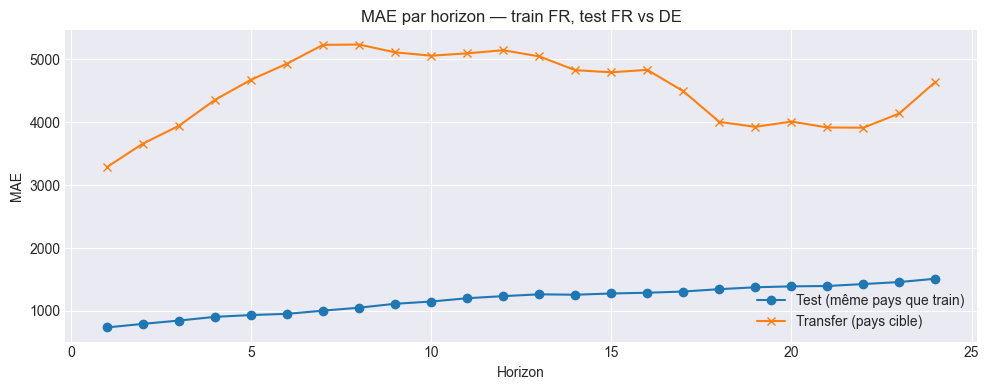

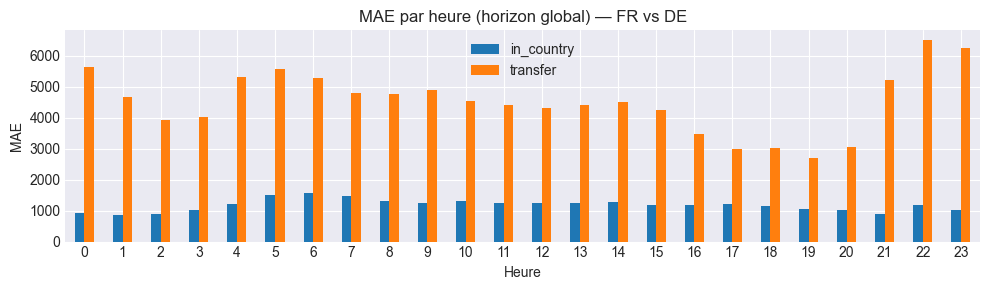

In [18]:
res_fr_de = plot_transfer_example("FR", "DE")


### Exemple 2 : ES → PT
Cas voisin géographiquement : la dégradation peut être plus faible (patterns plus proches), mais elle reste non nulle.


== Transfer SE → NO ==


,train_country_test,transfer_test
MAE,390.208588,594.659485
RMSE,599.449890,836.542786
MAPE,2.759649,3.916413


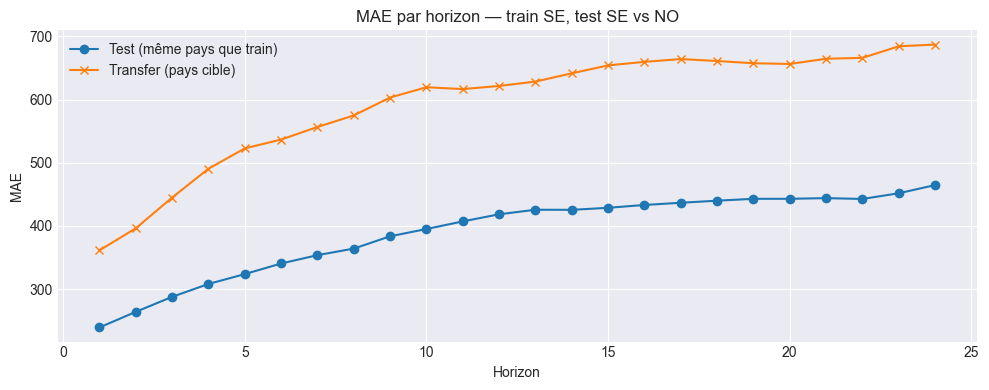

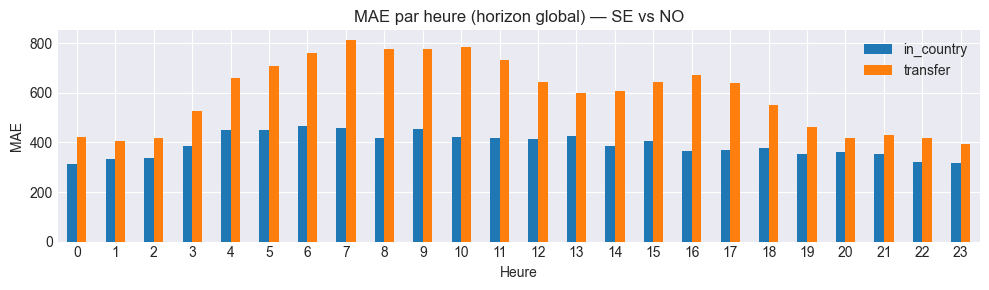

In [20]:
res_es_pt = plot_transfer_example("SE", "NO")


## Conclusion

- Ce notebook met en place une chaîne complète et reproductible : données → EDA → modèles → comparaison → analyse d’erreurs.
- **SARIMA** capture bien la saisonnalité (notamment journalière) et fournit un bon point de référence statistique, mais devient coûteux si on évalue des origines trop fréquentes.
- **LSTM** (avec historique de charge + validation/regularisation) est plus flexible pour apprendre des non-linéarités et combiner variables exogènes (température, calendrier) et lags.
- L’analyse d’erreurs (par heure) permet d’identifier les périodes difficiles, souvent liées aux pics (matin/soir) et aux changements de régime (semaine/weekend).

Pistes d’amélioration :
- ajuster systématiquement les hyperparamètres (fenêtre d’entrée, hidden size, LR) ;
- comparer d’autres architectures (TCN, N-BEATS) ;
- enrichir/ablation des variables (météo supplémentaire, jours fériés/vacances plus complets).
